Mesh resolution: Δx = 0.0016
L2 error: Method1 = 1.0527535870634885e-06, Method2 = 1.0527557899380368e-06
L2 norm between the two results: 2.63937994921989e-12


Text(0.5, 1.0, 'Mesh')

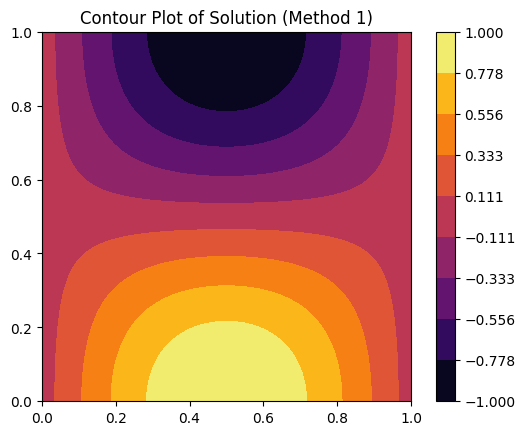

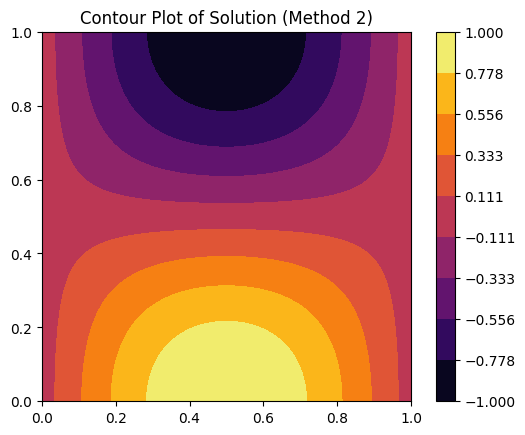

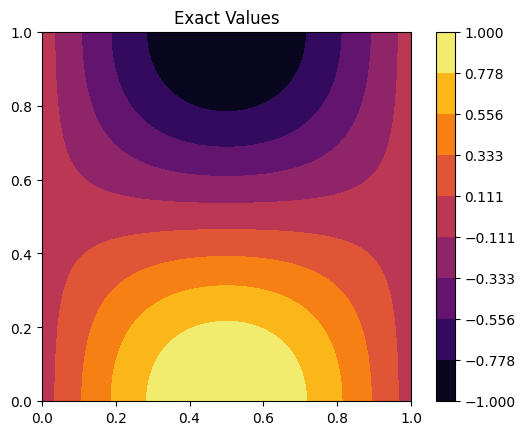

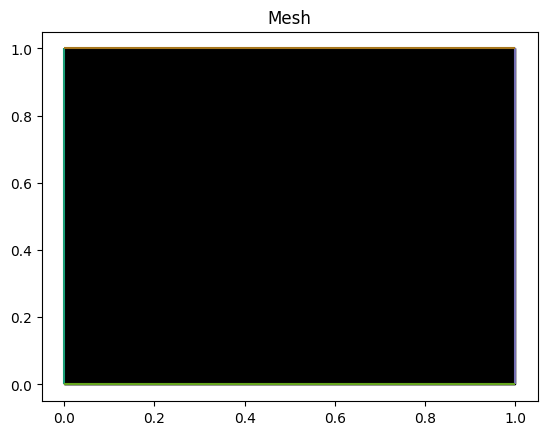

In [ ]:
#
# Solution by Firedrake FEM-CG of a Poisson equatiom
#
import matplotlib.pyplot as plt
import numpy as np
from firedrake import *
from firedrake.pyplot import tricontourf

#STEP 3: GENERATE MESH
nx = ny = 625 # Try various mesh resolutions, starting coarse, say 16x16 etc.

mesh = UnitSquareMesh(nx,ny,quadrilateral=True)
# Quadrilateral regular mesh made: https://www.firedrakeproject.org/firedrake.html#firedrake.utility_meshes.UnitSquareMesh
# Alternatively use gmsh: 

#ASSIGN FUNCTION SPACE, USED IN STEP 1 AND 2
V = FunctionSpace(mesh, 'CG', 1) # Piecewise linear continuous Galerkin function space or polynomials
# See: https://www.firedrakeproject.org/variational-problems.html

#STEP 1/2 FOR TEST FUNCTION METHOD 
# Method 1: construct the weak form manually by multiplying and manipulating the Poisson equation and solve the linear system
#
u = TrialFunction(V) # The unknown or variable u(x,y)
v = TestFunction(V)  # The testfunction of u, which may be better called delu or deltau

x, y = SpatialCoordinate(mesh) # Mesh coordinates

f = Function(V).interpolate(2*pi**2*sin(pi*x)*cos(pi*y)) # The given function f(x,y)

a = (inner(grad(u),grad(v)))*dx # Step 2/3: The weak form first term
L = (f*v)*dx # Step 2/3: The weak form second term; dx is the infinitesimal piece in the damain here: dx*dy=dA with area A.

u_1 = Function(V, name='u_1') # Name of solution for first method

bc_x0 = DirichletBC(V, Constant(0), 1) # Dirichlet boundary conditions imposed 
bc_x1 = DirichletBC(V, Constant(0), 2) # Dirichlet boundary conditions imposed 
# See: https://www.firedrakeproject.org/firedrake.html#firedrake.bcs.DirichletBC
# The homogeneous Neumann boundary conditions are "automatically" included, i.e. do not need anything explicit

#STEP 4: SOLVE
solve(a == L, u_1, solver_parameters={'ksp_type': 'cg', 'pc_type': 'none'}, bcs=[bc_x0,bc_x1]) # Step 4: the solution assigned to u1

# STEP 1/2 FOR VARIATION PRINCIPLE METHOD 
# Method 2: generate the weak form via "derivative()" of the Ritz-Galerkin integral or variational principle and solve the nonlinear system
#
u_2 = Function(V, name='u_2') # Name of solution for first method

Ju = (0.5*inner(grad(u_2),grad(u_2)) - u_2*f)*dx # f->ULF? Step 2

F = derivative(Ju, u_2, du=v) # Step 2/3: The weak form generated

#STEP 4: SOLVE 
solve(F == 0, u_2, bcs=[bc_x0, bc_x1]) # Step 4: the solution assigned to u2

# 
# Post-processing: Use Paraview to visualise
# See https://www.firedrakeproject.org/visualisation.html#creating-output-files
#outfile = VTKFile('output.pvd')
#outfile.write(u_1, u_2)

f.interpolate(sin(pi*x)*cos(pi*y))
L2_1 = sqrt(assemble(dot(u_1 - f, u_1 - f) * dx)) # L2 error solution u1
L2_2 = sqrt(assemble(dot(u_2 - f, u_2 - f) * dx)) # L2 error solution u2
L2 = sqrt(assemble(dot(u_2 - u_1, u_2 - u_1) * dx)) # L2 error difference
print(f'Mesh resolution: Δx = {1/nx}')
print(f'L2 error: Method1 = {L2_1}, Method2 = {L2_2}')
print(f'L2 norm between the two results: {L2}')


#Contour Plot 
fig, axes = plt.subplots()
levels = np.linspace(-1, 1, 10)
contours = tricontourf(u_1, levels=levels,  axes=axes, cmap="inferno")
axes.set_aspect("equal")
fig.colorbar(contours)
axes.set_title('Contour Plot of Solution (Method 1)')

#Contour Plot 
fig, axes = plt.subplots()
levels = np.linspace(-1, 1, 10)
contours = tricontourf(u_2, levels=levels,  axes=axes, cmap="inferno")
axes.set_aspect("equal")
fig.colorbar(contours)
axes.set_title('Contour Plot of Solution (Method 2)')

#Contour Plot 
fig, axes = plt.subplots()
levels = np.linspace(-1, 1, 10)
contours = tricontourf(f, levels=levels,  axes=axes, cmap="inferno")
axes.set_aspect("equal")
fig.colorbar(contours)
axes.set_title('Exact Values')

#Plot Mesh 
fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.set_title('Mesh')



In [ ]:

#SAVE results 
np.savetxt('meshx.txt', (mesh.coordinates.dat.data[:,0]), delimiter=',', fmt='%s') #x coordinates of meshpoints
np.savetxt('meshy.txt', (mesh.coordinates.dat.data[:,1]), delimiter=',', fmt='%s') #y coordinates of meshpoints
np.savetxt('u_1.txt', (u_1.dat.data), delimiter=',', fmt='%s')
np.savetxt('f.txt', (f.dat.data), delimiter=',', fmt='%s')

Text(0.5, 0.92, 'Method 2')

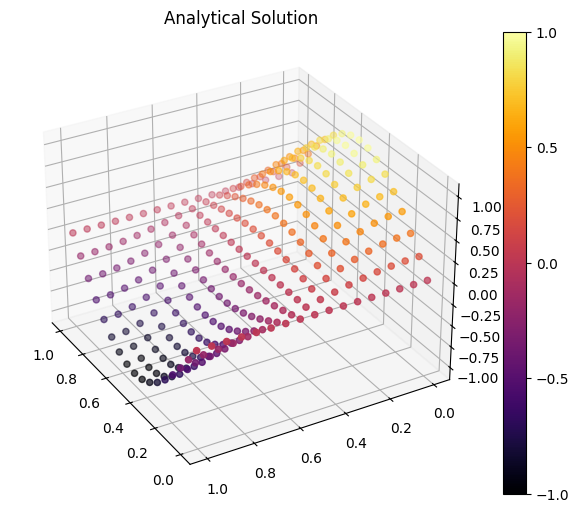

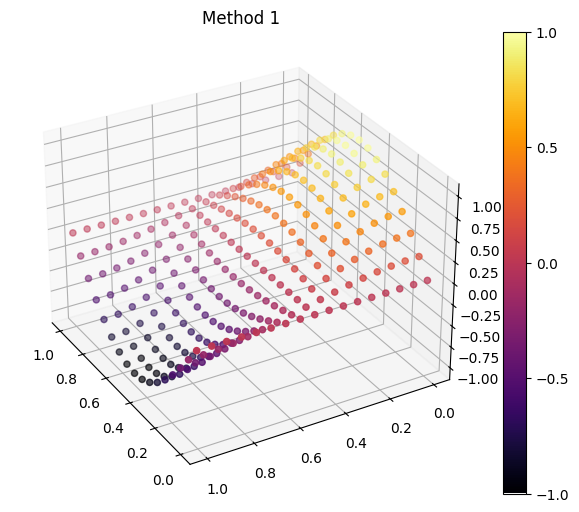

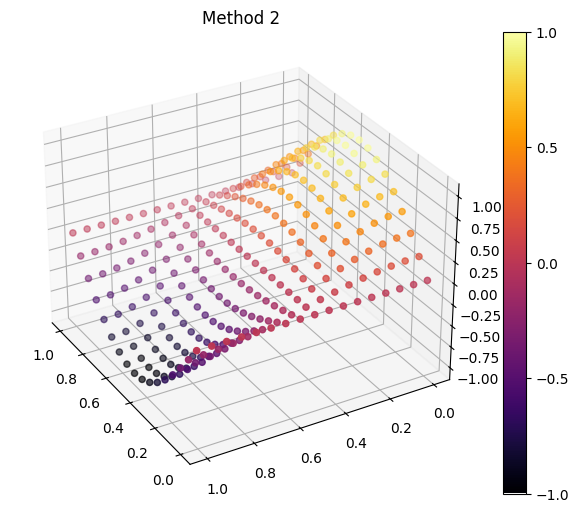

In [2]:
#TO PLOT AS A 3D SCATTER
x=mesh.coordinates.dat.data[:,0]
y=mesh.coordinates.dat.data[:,1]

#ANALYTICAL
z=f.dat.data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
p=ax.scatter3D(x, y, z,c=z, cmap='inferno', marker='o')
cb=fig.colorbar(p)
cb.set_ticks(np.linspace(-1,1,5))
ax.view_init(elev=30, azim=150,roll=0)
#ax.view_init(elev=90, azim=-90,roll=0) #view from above
ax.set_title("Analytical Solution")


#Method 1
z=u_1.dat.data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
p=ax.scatter3D(x, y, z,c=z, cmap='inferno', marker='o')
cb=fig.colorbar(p)
cb.set_ticks(np.linspace(-1,1,5))
ax.view_init(elev=30, azim=150,roll=0)
#ax.view_init(elev=90, azim=-90,roll=0) #view from above
ax.set_title("Method 1")

#Method 2
z=u_2.dat.data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
p=ax.scatter3D(x, y, z,c=z, cmap='inferno', marker='o')
cb=fig.colorbar(p)
cb.set_ticks(np.linspace(-1,1,5))
ax.view_init(elev=30, azim=150,roll=0)
#ax.view_init(elev=90, azim=-90,roll=0) #view from above
ax.set_title("Method 2")



'""\n#ANALYTICAL\nz=f.dat.data\nfig = plt.figure(figsize=(8,6))\nax = fig.add_subplot()\np=ax.scatter(x, y,c=z, cmap=\'inferno\', marker=\'o\')\ncb=fig.colorbar(p)\ncb.set_ticks(np.linspace(-1,1,5))\nax.set_title("Analytical Solution")\n\n#Method 1\nz=u_1.dat.data\nfig = plt.figure(figsize=(8,6))\nax = fig.add_subplot()\np=ax.scatter(x, y,c=z, cmap=\'inferno\', marker=\'o\')\ncb=fig.colorbar(p)\ncb.set_ticks(np.linspace(-1,1,5))\nax.set_title("Method 1")\n\n#Method 2\nz=u_2.dat.data\nfig = plt.figure(figsize=(8,6))\nax = fig.add_subplot()\np=ax.scatter(x, y,c=z, cmap=\'inferno\', marker=\'o\')\ncb=fig.colorbar(p)\ncb.set_ticks(np.linspace(-1,1,5))\nax.set_title("Method 2")\n\n'

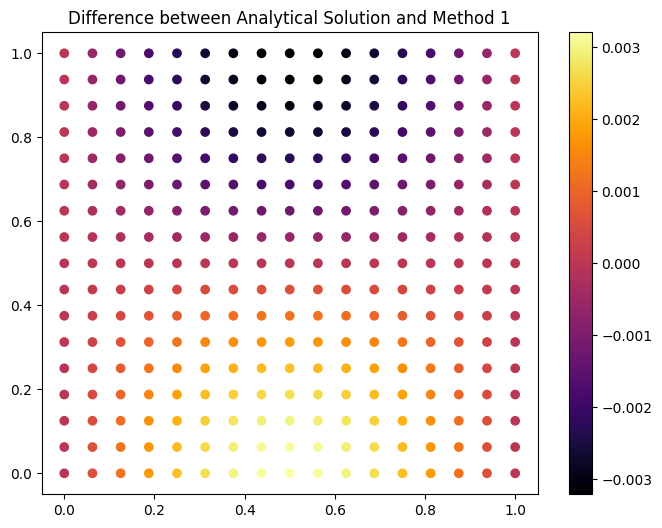

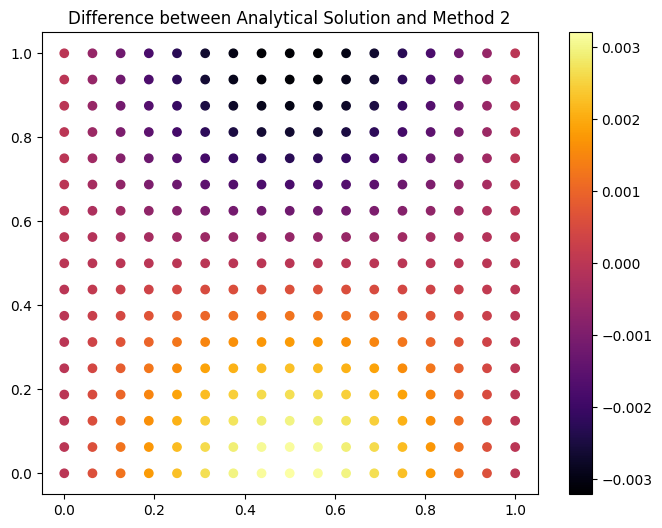

In [3]:
#TO PLOT DIFFERENCE AS A 2D SCATTER with Colours
x=mesh.coordinates.dat.data[:,0]
y=mesh.coordinates.dat.data[:,1]

#ANALYTICAL - METHOD 1
z=f.dat.data-u_1.dat.data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
p=ax.scatter(x, y,c=z, cmap='inferno', marker='o')
cb=fig.colorbar(p)
#cb.set_ticks(np.linspace(-1,1,5))
ax.set_title("Difference between Analytical Solution and Method 1")

#ANALYTICAL - METHOD 2
z=f.dat.data-u_2.dat.data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
p=ax.scatter(x, y,c=z, cmap='inferno', marker='o')
cb=fig.colorbar(p)
#cb.set_ticks(np.linspace(-1,1,5))
ax.set_title("Difference between Analytical Solution and Method 2")

"""""
#ANALYTICAL
z=f.dat.data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
p=ax.scatter(x, y,c=z, cmap='inferno', marker='o')
cb=fig.colorbar(p)
cb.set_ticks(np.linspace(-1,1,5))
ax.set_title("Analytical Solution")

#Method 1
z=u_1.dat.data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
p=ax.scatter(x, y,c=z, cmap='inferno', marker='o')
cb=fig.colorbar(p)
cb.set_ticks(np.linspace(-1,1,5))
ax.set_title("Method 1")

#Method 2
z=u_2.dat.data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
p=ax.scatter(x, y,c=z, cmap='inferno', marker='o')
cb=fig.colorbar(p)
cb.set_ticks(np.linspace(-1,1,5))
ax.set_title("Method 2")

"""